5.874444444444444
42.28194444444444
1.0564601740888366
0.3024820571405893
simulating time: 20.464128732681274s
8.054444444444444
46.57861111111111
1.0442255896613704
0.3800427095468885
simulating time: 19.61698842048645s


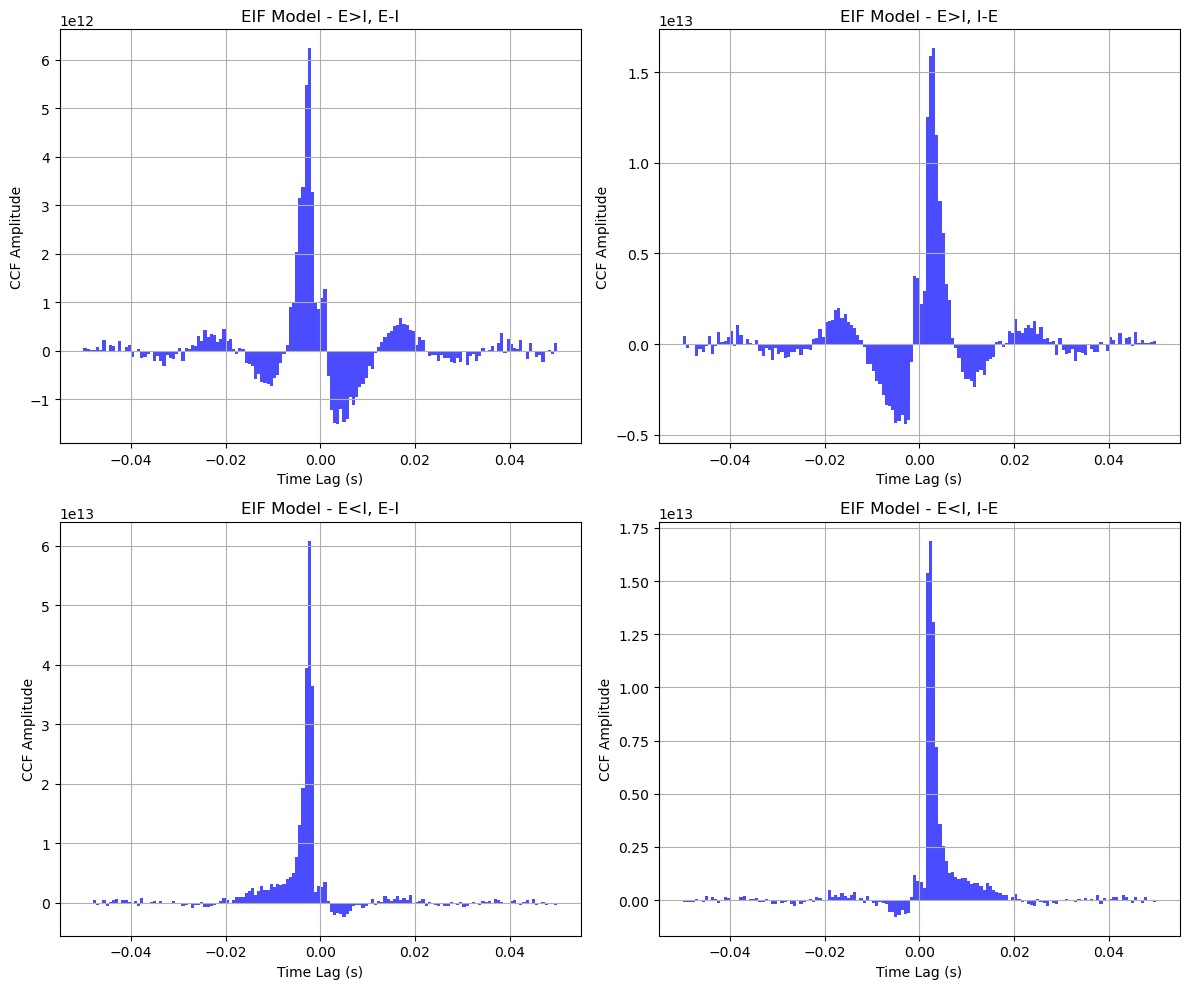

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import time
import ctypes
from numba import njit, prange
import os
os.add_dll_directory("C:/msys64/mingw64/bin")  # Allow Python to find the FFTW3 dependency
# Load the C++ shared library
fftw_lib = ctypes.CDLL("C:/Users/syzha/Desktop/fast_correlate.dll")

fftw_lib.fft_correlate.argtypes = [
    ctypes.POINTER(ctypes.c_double),  # x
    ctypes.POINTER(ctypes.c_double),  # y
    ctypes.POINTER(ctypes.c_double),  # result
    ctypes.c_int                      # N
]
fftw_lib.fft_correlate.restype = None 

tau_m = np.array([10e-3, 10e-3])             # Membrane time constant (s)
tau_s = np.array([3e-3, 3e-3])              # Synaptic conductance decay time constant (s)
ep_s = np.array([[0, 1.5e-3],[1.5e-3, 0]])
g_m = np.array([25e-9, 25e-9])            # Membrane conductance (S)
C_m = np.array([250e-12,250e-12])             # Membrane capacitance (F)
V_rest = np.array([0e-3, 0e-3])             # Resting potential (V)
V_reset = np.array([3e-3, 3e-3])            # Reset potential (V)
V_threshold = np.array([10e-3, 10e-3])       # Action potential threshold (V)
delta_T = np.array([1e-3, 1e-3])            # Spike-triggering parameter for EIF (V)
E_syn = np.array([0e-3, 0e-3])           # Synaptic reversal potential (V)
I_0 = np.array([400e-12, 400e-12])              # Mean background current 
num = 2
# Time settings
T_sim = 3600.0             # Total simulation time (s)
dt = 1e-4                 # Time step (s)

time1 = np.arange(0, T_sim, dt)
decay = np.exp(-dt / tau_s)
syn_decay = np.int32(ep_s/dt)
firing_rate_pre = 0   # Presynaptic neuron firing rate (Hz)  ?

@njit
def poisson_syn():
    return np.random.poisson(lam=firing_rate_pre * dt, size=len(time1))
    
spike_train_pre = poisson_syn()
@njit
def generate_background_g(I_0, sigma_g):
    return I_0 + sigma_g * np.sqrt(g_m * C_m / dt) * np.random.randn(*I_0.shape)
    
    
@njit
def simulate_LIF_with_background(num, spike_train_pre, tau_m, g_m, C_m,sigma_g, g_0, E_syn, I_0):

    V = np.zeros((num, len(time1)))
    V[:, 0] = V_rest
    spike_train_post = np.zeros((num,len(time1)))
    g_syn = np.zeros(num)
    mask = np.zeros(num)
    for t in range(1, len(time1)):
        g_syn = g_syn * decay
        # Synaptic conductance and background activity
        for j in range(num):
            for k in range(num):
                jk_delay = t - syn_decay[j, k]
                if jk_delay >= 0:
                    g_syn[j] += g_0[j, k] * spike_train_post[k, jk_delay] 
        i_b = generate_background_g(I_0, sigma_g)
        I_syn = i_b   # can add a common input
        # membrane potential
        dV = (-(V[:, t-1] - V_rest) / tau_m + I_syn / C_m + g_syn*(E_syn - V[:, t-1])/ C_m) * dt
        V[:, t] = V[:, t-1] + dV
        # check firing
        temp = V[:, t]
        mask = V[:, t] >= V_threshold
        temp[mask]= V_reset[mask]
        V[:, t] = temp
        temp = spike_train_post[:, t]
        temp[mask] = 1
        spike_train_post[:, t] = temp
    #print(sum(spike_train_post[1]))
    return spike_train_post, V
    
def compute_Cv(spike_train_post):
    spi = np.where(spike_train_post==1)[0]
    interval = []
    for i in range(1, len(spi)):
        interval += [spi[i] - spi[i-1]]
    Cv = np.std(interval)/np.mean(interval)
    print(Cv)
    
@njit
def simulate_EIF_with_background(num, spike_train_pre, tau_m, g_m, C_m,sigma_g, g_0, E_syn, I_0):

    V = np.zeros((num, len(time1)))
    V[:, 0] = V_rest
    spike_train_post = np.zeros((num,len(time1)))
    g_syn = np.zeros(num)
    mask = np.zeros(num)
    for t in range(1, len(time1)):
        g_syn = g_syn * decay
        # Synaptic conductance and background activity
        for j in range(num):
            for k in range(num):
                jk_delay = t - syn_decay[j, k]
                if jk_delay >= 0:
                    g_syn[j] += g_0[j, k] * spike_train_post[k, jk_delay] 
        i_b = generate_background_g(I_0, sigma_g)
        I_syn = i_b   # can add a common input
        # membrane potential
        dV = (-(V[:, t-1] - V_rest) / tau_m + I_syn / C_m + g_syn*(E_syn - V[:, t-1])/ C_m) * dt
        dV += delta_T * np.exp((V[:, t-1] - V_threshold) / delta_T) * dt / tau_m
        V[:, t] = V[:, t-1] + dV
        # check firing
        temp = V[:, t]
        mask = V[:, t] >= V_threshold
        temp[mask]= V_reset[mask]
        V[:, t] = temp
        temp = spike_train_post[:, t]
        temp[mask] = 1
        spike_train_post[:, t] = temp
    print(sum(spike_train_post[0])/T_sim)
    print(sum(spike_train_post[1])/T_sim)
    return spike_train_post, V
    

def fast_correlate(x, y):
    N = len(x)

    mean_x, mean_y = np.mean(x), np.mean(y)
    x, y = x - mean_x, y - mean_y

    x = np.ascontiguousarray(x, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    result = np.zeros(2 * N - 1, dtype=np.float64)

    x_ctypes = x.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_ctypes = y.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    result_ctypes = result.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

    fftw_lib.fft_correlate(x_ctypes, y_ctypes, result_ctypes, N)
    #result = np.roll(result, N - 1)
    return result
    

def compute_CCF(spike_train, begin, end, g_m, g_0, E_syn, I_0):
    ccf = fast_correlate(spike_train[end], spike_train[begin])
    N = len(spike_train[end])
    lag = np.arange(-N + 1, N) * dt

    mask = (lag >= -50e-3) & (lag <= 50e-3)
    ccf_norm = ccf /np.abs((g_0[end, begin]*(E_syn[end] - I_0[end]/g_m[end])))
    return ccf_norm[mask], lag[mask]

start_time = time.time()
spike_train_post_EIF_low, _ = simulate_EIF_with_background(  # Use different parameters here
    2, spike_train_pre, tau_m=tau_m, g_m=g_m, C_m=C_m, sigma_g = np.array([8e-3, 1e-3]), g_0 = np.array([[0, 30e-9],[10e-9, 0]]), 
    E_syn = np.array([-11e-3, 20e-3]), I_0 = np.array([-28e-12, 252e-12])
)#mu1=-1mV, mu2 = 10mV
compute_Cv(spike_train_post_EIF_low[0])
compute_Cv(spike_train_post_EIF_low[1])
end_time = time.time()
execution_time = end_time - start_time
print(f"simulating time: {execution_time}s")
ccf_EIF_low1, lag_EIF_low1 = compute_CCF(spike_train_post_EIF_low, 1, 0, g_m=g_m, g_0 = np.array([[0, 30e-9],[10e-9, 0]]), 
    E_syn = np.array([-11e-3, 20e-3]), I_0 = np.array([-28e-12, 252e-12]))
ccf_EIF_low2, lag_EIF_low2 = compute_CCF(spike_train_post_EIF_low, 0, 1, g_m=g_m, g_0 = np.array([[0, 30e-9],[10e-9, 0]]), 
    E_syn = np.array([-11e-3, 20e-3]), I_0 = np.array([-28e-12, 252e-12]))
start_time = time.time()
spike_train_post_EIF_low, _ = simulate_EIF_with_background(
    2, spike_train_pre, tau_m=tau_m, g_m=g_m, C_m=C_m, sigma_g = np.array([8e-3, 1e-3]), g_0 = np.array([[0, 10e-9],[30e-9, 0]]), 
    E_syn = np.array([-11e-3, 20e-3]), I_0 = np.array([-28e-12, 252e-12])
)#mu1=-1mV, mu2 = 10mV
compute_Cv(spike_train_post_EIF_low[0])
compute_Cv(spike_train_post_EIF_low[1])
end_time = time.time()
execution_time = end_time - start_time
print(f"simulating time: {execution_time}s")
ccf_EIF_low3, lag_EIF_low3 = compute_CCF(spike_train_post_EIF_low, 1, 0, g_m=g_m, g_0 = np.array([[0, 10e-9],[30e-9, 0]]), 
    E_syn = np.array([-11e-3, 20e-3]), I_0 = np.array([-28e-12, 252e-12]))
ccf_EIF_low4, lag_EIF_low4 = compute_CCF(spike_train_post_EIF_low, 0, 1, g_m=g_m, g_0 = np.array([[0, 10e-9],[30e-9, 0]]), 
    E_syn = np.array([-11e-3, 20e-3]), I_0 = np.array([-28e-12, 252e-12]))

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(lag_EIF_low1, bins=150, weights=ccf_EIF_low1, color="blue", alpha=0.7)
plt.title("EIF Model - E>I, E-I")
plt.xlabel("Time Lag (s)")
plt.ylabel("CCF Amplitude")
plt.grid()
plt.subplot(2, 2, 2)
plt.hist(lag_EIF_low2, bins=150, weights=ccf_EIF_low2, color="blue", alpha=0.7)
plt.title("EIF Model - E>I, I-E")
plt.xlabel("Time Lag (s)")
plt.ylabel("CCF Amplitude")
plt.grid()
plt.subplot(2, 2, 3)
plt.hist(lag_EIF_low3, bins=150, weights=ccf_EIF_low3, color="blue", alpha=0.7)
plt.title("EIF Model - E<I, E-I")
plt.xlabel("Time Lag (s)")
plt.ylabel("CCF Amplitude")
plt.grid()
plt.subplot(2, 2, 4)
plt.hist(lag_EIF_low4, bins=150, weights=ccf_EIF_low4, color="blue", alpha=0.7)
plt.title("EIF Model - E<I, I-E")
plt.xlabel("Time Lag (s)")
plt.ylabel("CCF Amplitude")
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
# SRM v0.0
import numpy as np
import matplotlib.pyplot as plt
import time
import ctypes
import math
from numba import njit, prange
import os
print(os.path.exists("C:/Users/syzha/Desktop/fast_correlate.dll"))
os.add_dll_directory("C:/msys64/mingw64/bin")  # Allow Python to find the FFTW3 dependency
# Load the C++ shared library
fftw_lib = ctypes.CDLL("C:/Users/syzha/Desktop/fast_correlate.dll")

fftw_lib.fft_correlate.argtypes = [
    ctypes.POINTER(ctypes.c_double),  # x
    ctypes.POINTER(ctypes.c_double),  # y
    ctypes.POINTER(ctypes.c_double),  # result
    ctypes.c_int                      # N
]
fftw_lib.fft_correlate.restype = None

R = 36e6  # Input resistance (Ohm)
V_th = 10e-3  # Threshold voltage (V)
eta_0 = -22e-3  # Reset voltage (V)
# Time constants
tau_m = 4e-3  # Membrane time constant (s)
tau_refr = 100e-3  # Refractory time constant (s)
tau_rec = 100e-3  # Response recovery time constant (s)

# Input current
I0 = 1.0e-9  # Constant input current (A)
tau_s = 0.5e-3 # Syn time constant (s)
#I_s = 1.1e-9 # I_syn (A)
ep_s = 0e-3 # Syn delay (s)

#escape noise
#sigma_u = 0.9e-3 # Noise std
tau =  4 # constant ?

# Time settings
T_sim = 3600.0             # Total simulation time (s)
dt = 0.1e-3                 # Time step (s)

time1 = np.arange(0, T_sim, dt)
decay = np.exp(-dt / tau_s)
syn_delay = np.int32(ep_s/dt)
firing_rate_pre = 50   # Presynaptic neuron firing rate (Hz)

@njit
def poisson_syn():
    return np.random.poisson(lam = firing_rate_pre * dt, size=len(time1))
    
spike_train_pre = poisson_syn()

@njit
def noise(u, u_d, V_th, sigma_u, tau, dt):
    G = np.exp(-((u - V_th) ** 2) / (2 * sigma_u ** 2)) / (sigma_u * np.sqrt(2 * np.pi))
    escape_rate = 1.21 * ((1 / tau) + 2 * u_d * (u_d > 0)) * (G / math.erfc((u - V_th) / (np.sqrt(2) * sigma_u)))
    return 1 - np.exp(-dt * escape_rate)
    
@njit
def simulate_SRM_with_background(spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s, sigma_u,):

    u = np.zeros(len(time1))
    r = np.zeros(len(time1)) 
    h_free = np.zeros(len(time1))
    spike_train_post = np.zeros(len(time1))
    I_syn = 0
    I_aux = 0
    for t in range(1, len(time1)):
        # Synaptic current and background activity
        if t - syn_delay >= 0:
            I_syn = I_syn * decay + I_aux * dt
            I_aux = (I_aux + I_s/tau_s * spike_train_pre[t - syn_delay])* decay
        I = I0 + I_syn
    # membrane potential
        du_dt = (-u[t-1] + h_free[t-1] * (1 - tau_refr / tau_m) + (1 - r[t-1]) * (tau_refr / tau_m) * R * I - r[t-1] * h_free[t-1] * (1 - tau_refr * (1/tau_m + 1/tau_rec))) / tau_refr
        dr_dt = -r[t-1] / tau_rec
        dh_free_dt = (-h_free[t-1] + R * I) / tau_m
    # Update variables
        u[t] = u[t-1] + dt * du_dt
        r[t] = r[t-1] + dt * dr_dt
        h_free[t] = h_free[t-1] + dt * dh_free_dt
    # Check if a spike occurs
        Noi = noise(u[t], du_dt, V_th, sigma_u, tau, dt)
        th = np.random.rand()
        #print(du_dt)
        if th < Noi:
            #print(th, u[t], Noi)
            u[t] = eta_0  # Reset membrane potential
            r[t] = 1  # Set recovery variable to 1
            h_free[t] = 0  # Clear free membrane potential
            spike_train_post[t] = 1
    return spike_train_post, u


def fast_correlate(x, y):
    N = len(x)

    mean_x, mean_y = np.mean(x), np.mean(y)
    #x, y = x - mean_x, y - mean_y

    x = np.ascontiguousarray(x, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    result = np.zeros(2 * N - 1, dtype=np.float64)

    x_ctypes = x.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_ctypes = y.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    result_ctypes = result.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

    fftw_lib.fft_correlate(x_ctypes, y_ctypes, result_ctypes, N)
    #result = np.roll(result, N - 1)
    return result
    '''
def fast_correlate(x, y):
    N = len(x)
    mean_x, mean_y = np.mean(x), np.mean(y)

    fft_size = 2 ** (int(np.log2(2 * N - 1)) + 1)

    X = np.fft.fft(x, fft_size)
    Y = np.fft.fft(y, fft_size)

    corr = np.fft.ifft(X * np.conj(Y)).real
    corr = np.roll(corr, N - 1)[: 2 * N - 1]

    return corr
'''
def compute_CCF(spike_train_pre, spike_train_post, dt, T_sim = T_sim):
    ccf = fast_correlate(spike_train_post, spike_train_pre)
    N = len(spike_train_pre)
    lag = np.arange(-N + 1, N) * dt
    mask = (lag >= 0) & (lag < 20e-3)
    ccf_norm = ccf/T_sim/dt/firing_rate_pre
    return ccf_norm[mask], lag[mask]

spike_trains = []
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s,  tau, dt, time1, decay, syn_delay, I_s = 1.088e-9, sigma_u = 0.9e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s,  tau, dt, time1, decay, syn_delay, I_s = -1.088e-9, sigma_u = 0.9e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = 1.088e-9, sigma_u = 2.25e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = -1.088e-9, sigma_u = 2.25e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = 0.272e-9, sigma_u = 0.9e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = -0.272e-9, sigma_u = 0.9e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = 0.272e-9, sigma_u = 2.25e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = -0.272e-9, sigma_u = 2.25e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s,  tau, dt, time1, decay, syn_delay, I_s = 0.4e-9, sigma_u = 0.9e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s,  tau, dt, time1, decay, syn_delay, I_s = -0.4e-9, sigma_u = 0.9e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = 0.4e-9, sigma_u = 2.25e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = -0.4e-9, sigma_u = 2.25e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = 0.1e-9, sigma_u = 0.9e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = -0.1e-9, sigma_u = 0.9e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = 0.1e-9, sigma_u = 2.25e-3
)
spike_trains += [spike_train_post]
spike_train_post, V = simulate_SRM_with_background(
    spike_train_pre, R, V_th, eta_0, tau_m, tau_refr, tau_rec, I0, tau_s, tau, dt, time1, decay, syn_delay, I_s = -0.1e-9, sigma_u = 2.25e-3
)
spike_trains += [spike_train_post]
ccf = []
lag = []
print("Compute CCG.")
for st in spike_trains:
    ccf1, lag1 = compute_CCF(spike_train_pre, st, dt=0.1e-3, T_sim=T_sim)
    ccf += [ccf1]
    lag += [lag1]

True
Compute CCG.


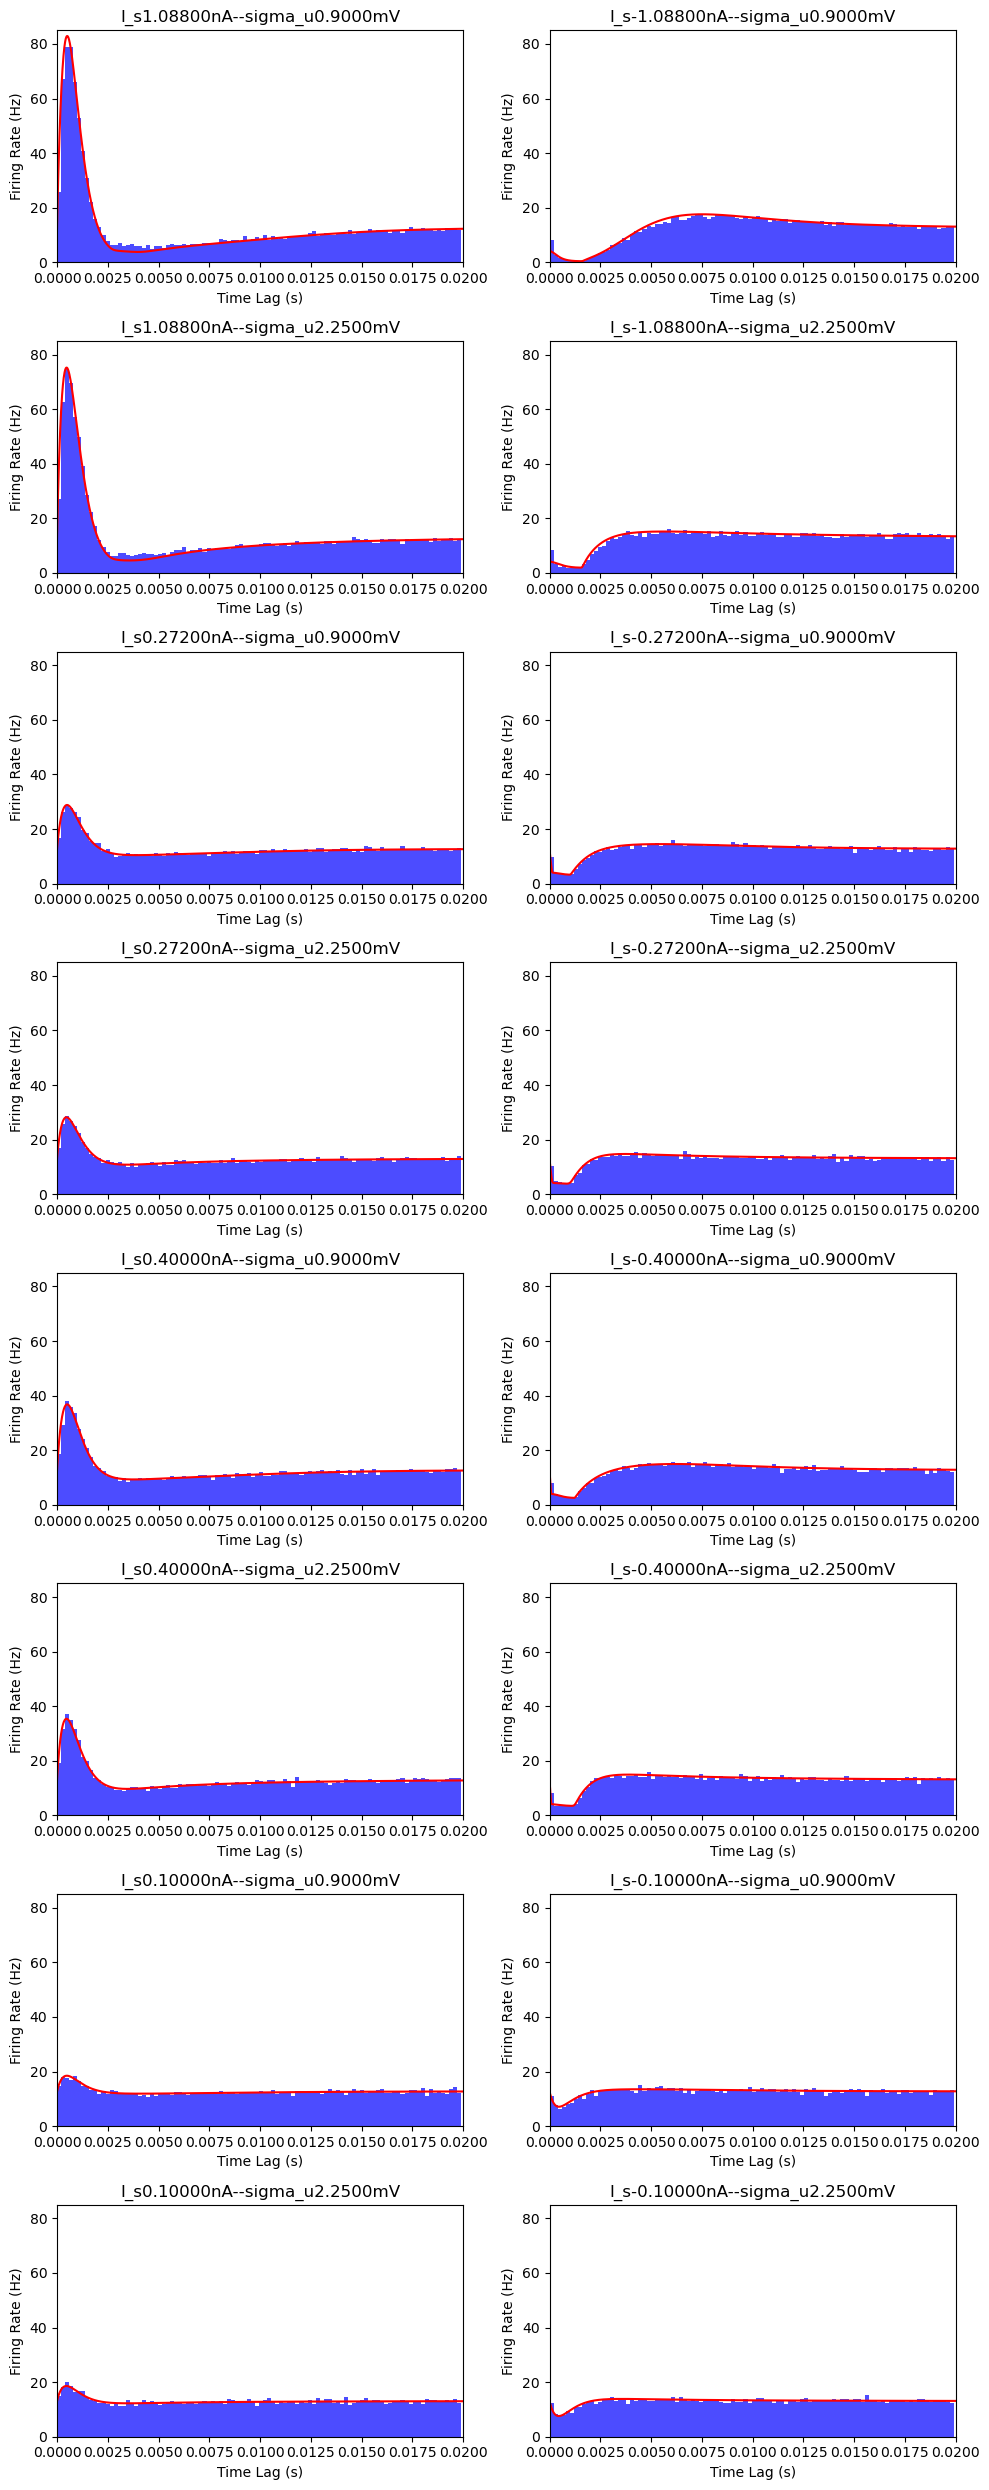

In [29]:
import pickle
with open("CCG_res.pk", "rb") as f:
    data = pickle.load(f)
keys_list = list(data.keys())
fig, axes = plt.subplots(8, 2, figsize=(10, 25))

for i, ax in enumerate(axes.flatten()):
    ax.hist(lag[i], bins=100, weights=ccf[i]/2, color="blue", alpha=0.7)
    ax.plot(np.arange(0, 20e-3, 0.1*dt), data[keys_list[i]], 'r-')
    ax.set_xlabel("Time Lag (s)")
    ax.set_ylabel("Firing Rate (Hz)")
    ax.set_title(keys_list[i])
    ax.set_xlim(0, 20e-3)
    ax.set_ylim(0, 85)
plt.tight_layout()
plt.show()